In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aurora-hackathon/new_train.csv
/kaggle/input/aurora-hackathon/new_test.csv


In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 18.0 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


### Step 1: Importing the Relevant Libraries

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [23]:
train = pd.read_csv('../input/aurora-hackathon/new_train.csv')
test = pd.read_csv('../input/aurora-hackathon/new_test.csv')

In [24]:
train.shape,test.shape

((11323, 2), (3561, 1))

* We have 11323 rows and 2 columns in Train set whereas Test set has 3561 rows and 1 column.

In [25]:
train.head()

,date,temp
0,01-01-1980,4.16
1,02-01-1980,4.06
2,03-01-1980,7.12
3,04-01-1980,9.23
4,05-01-1980,3.20


In [26]:
test.head()

,date
0,01-01-2011
1,02-01-2011
2,03-01-2011
3,04-01-2011
4,05-01-2011


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    11323 non-null  object 
 1   temp    11323 non-null  float64
dtypes: float64(1), object(1)
memory usage: 177.0+ KB


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3561 non-null   object
dtypes: object(1)
memory usage: 27.9+ KB


In [29]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [30]:
train.set_index('date',inplace=True)
test.set_index('date',inplace=True)

In [31]:
train.head()

,temp
date,
1980-01-01,4.16
1980-02-01,4.06
1980-03-01,7.12
1980-04-01,9.23
1980-05-01,3.20


In [32]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


In [34]:
#ratio of null values
train.isnull().sum()/train.shape[0] *100

temp    0.0
dtype: float64

* No need of data cleaning is required.

### Step 3: Data Visualization

<AxesSubplot:xlabel='date'>

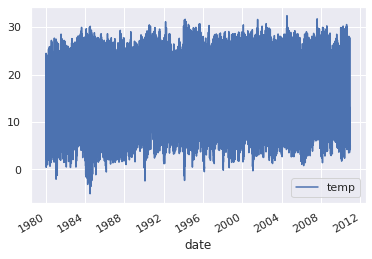

In [36]:
train.plot()

In [37]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [38]:
test_result=adfuller(train['temp'])

In [39]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(temperature):
    result=adfuller(temperature)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [40]:
adfuller_test(train['temp'])

ADF Test Statistic : -10.24507580260355
p-value : 4.6405019261563845e-18
#Lags Used : 40
Number of Observations Used : 11282
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


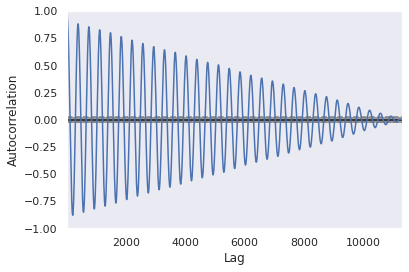

In [41]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train['temp'])
plt.show()

In [42]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

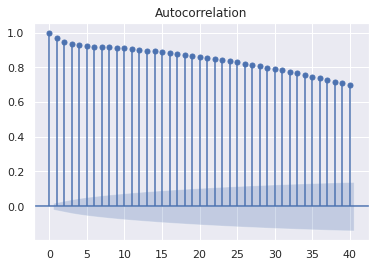

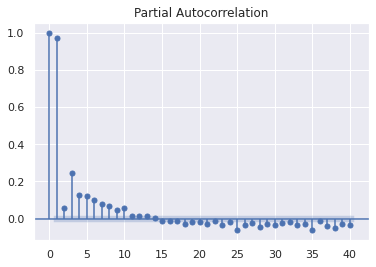

In [46]:
plot_acf(train, lags=40)
plt.show()
plot_pacf(train, lags=40)
plt.show()

In [49]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [50]:
arima_model = arimamodel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46803.901, Time=1.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=78876.978, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46880.898, Time=0.49 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=66608.663, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=96890.436, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46846.661, Time=3.68 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45647.237, Time=7.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=59827.049, Time=5.48 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45507.079, Time=6.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=45503.218, Time=17.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=45511.184, Time=12.35 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=45515.184, Time=20.57 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=45508.208, Time=12.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=45505.444, Time=15.88 sec
 ARIMA(4,0,1)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11323
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -22744.609
Date:                Mon, 08 Mar 2021   AIC                          45503.218
Time:                        12:25:34   BIC                          45554.560
Sample:                             0   HQIC                         45520.490
                              - 11323                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0434      0.011      4.086      0.000       0.023       0.064
ar.L1          1.3915      0.047     29.519      0.000       1.299       1.484
ar.L2         -0.4800      0.078     -6.173      0.000      -0.632      -0.328
ar.L3          0.0857      0.033      2.590      0.010       0.021       0.151
ma.L1         -0.5692      0.047    -12.137      0.000      -0.661      -0.477
ma.L2         -0.1622      0.042     -3.826      0.000      -0.245      -0.079
sigma2         3.2519      0.038     86.209      0.000       3.178       3.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               814.73
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.42
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Step 4: Model Building

#### Arima Model

In [51]:
from statsmodels.tsa.arima_model import ARIMA

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


plotting ARIMA Model


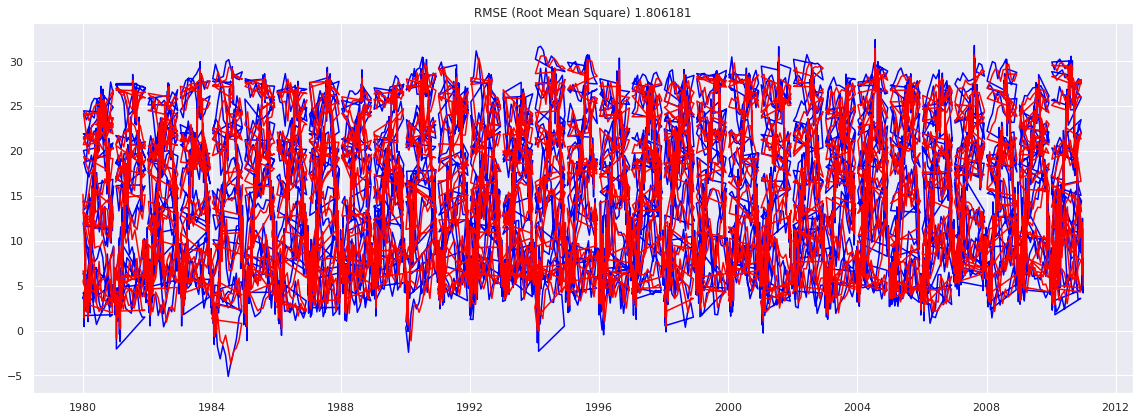

In [52]:
model = ARIMA(train, order = (3, 0,2)) 
results_ARIMA = model.fit(disp = -1)
plt.figure(figsize=(16, 6))
plt.plot(train, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title("RMSE (Root Mean Square) %f" %np.sqrt(mean_squared_error(results_ARIMA.fittedvalues, train['temp'])))
print("plotting ARIMA Model")
plt.tight_layout()
plt.show()

In [53]:
results_ARIMA.predict(start=0, end=9)

date
1980-01-01    15.167884
1980-02-01     4.486415
1980-03-01     4.376106
1980-04-01     7.069607
1980-05-01     8.281379
1980-06-01     3.109944
1980-07-01     7.687102
1980-08-01     3.307892
1980-09-01     3.366127
1980-10-01     5.161603
dtype: float64

In [54]:
results_ARIMA.fittedvalues.head(10)

date
1980-01-01    15.167884
1980-02-01     4.486415
1980-03-01     4.376106
1980-04-01     7.069607
1980-05-01     8.281379
1980-06-01     3.109944
1980-07-01     7.687102
1980-08-01     3.307892
1980-09-01     3.366127
1980-10-01     5.161603
dtype: float64

#### Sarima Model

In [55]:
import statsmodels.api as sm

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


plotting SARIMA Model


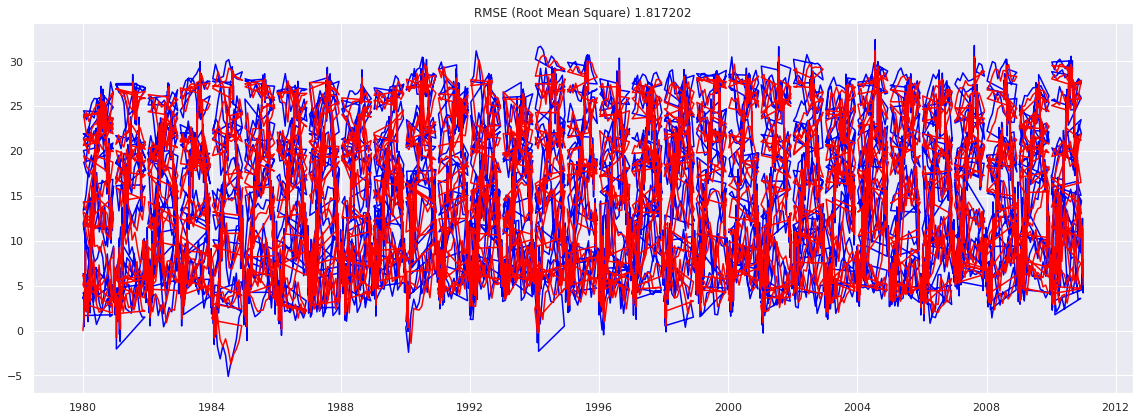

In [56]:
model=sm.tsa.statespace.SARIMAX(train ,order=(3, 0, 2),seasonal_order=(3,0,2,12))
results_SARIMA = model.fit(disp = -1)
plt.figure(figsize=(16, 6))
plt.plot(train, color='blue')
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title("RMSE (Root Mean Square) %f" %np.sqrt(mean_squared_error(results_SARIMA.fittedvalues, train['temp'])))
print("plotting SARIMA Model")
plt.tight_layout()
plt.show()

* After comparing the rmse values, it can be observed that ARIMA model is a better fit.

In [63]:
pred = results_ARIMA.predict(start=len(train), end=len(train)+3560, typ='levels').rename('prediction')
index_future_dates = pd.date_range(start='01-01-2011', end='2020-09-30')
pred.index=index_future_dates

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [64]:
pred

2011-01-01     6.026914
2011-01-02     6.313373
2011-01-03     6.373941
2011-01-04     6.398431
2011-01-05     6.427988
                ...    
2020-09-26    15.167881
2020-09-27    15.167881
2020-09-28    15.167881
2020-09-29    15.167881
2020-09-30    15.167881
Freq: D, Name: prediction, Length: 3561, dtype: float64

In [68]:
pred.to_csv('my_submission.csv', index= False)